In [1]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inlineimport sys
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

plt.style.use('ggplot') 
%matplotlib inline

UsageError: unrecognized arguments: sys


# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate chart data for the first 24hrs of a patients icu stay as well as demographic data for patients diagnosed with sepsis according to the Angus criteria. 
(Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file CHART_EVENTS_ANGUS_FIRST24.csv. The data was read into a pandas dataframe lab_events. 


In [25]:
data = pd.DataFrame.from_csv('CHART_EVENTS_FIRST24.csv')
data.head()  

,gender,icustay_id,charttime,label,value,valuenum,hospital_expire_flag
subject_id,,,,,,,
55973,F,200001,2181-11-26 16:55:00,GCS - Motor Response,Obeys Commands,6.0,0
55973,F,200001,2181-11-26 14:00:00,Heart Rate,103,103.0,0
55973,F,200001,2181-11-26 15:00:00,Respiratory Rate,30,30.0,0
55973,F,200001,2181-11-26 15:00:00,Heart Rate,98,98.0,0
55973,F,200001,2181-11-26 16:55:00,GCS - Verbal Response,Oriented,5.0,0


## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [26]:
data['subject_id'] = data.index
data.set_index(np.arange(data.shape[0]), inplace = True)
cols = list(data.columns)
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
data = data[cols]



In [27]:
data.head()

,icustay_id,subject_id,gender,charttime,label,value,valuenum,hospital_expire_flag
0,200001,55973,F,2181-11-26 16:55:00,GCS - Motor Response,Obeys Commands,6.0,0
1,200001,55973,F,2181-11-26 14:00:00,Heart Rate,103,103.0,0
2,200001,55973,F,2181-11-26 15:00:00,Respiratory Rate,30,30.0,0
3,200001,55973,F,2181-11-26 15:00:00,Heart Rate,98,98.0,0
4,200001,55973,F,2181-11-26 16:55:00,GCS - Verbal Response,Oriented,5.0,0


In [28]:
data2 = data.drop_duplicates('icustay_id', keep = 'first')
data3 = data.drop_duplicates('subject_id', keep = 'first')
print "The number of unique ICU stays = {}".format(data2.shape[0])
print "The number of unique patients  = {}".format(data3.shape[0])

The number of unique ICU stays = 60164
The number of unique patients  = 45969


In [29]:
# display the different measurements captured in the database query
labels = list(data.label.unique())
display(data.shape)
display(data[(data.label=='Capillary Refill') & (data.value.dropna())].head())
display(labels)

(6667722, 8)

,icustay_id,subject_id,gender,charttime,label,value,valuenum,hospital_expire_flag
1183,200017,15909,M,2138-03-18 04:00:00,Capillary Refill,Brisk,NaN,0
1185,200017,15909,M,2138-03-18 12:30:00,Capillary Refill,Brisk,NaN,0
1187,200017,15909,M,2138-03-17 23:00:00,Capillary Refill,Brisk,NaN,0
1189,200017,15909,M,2138-03-18 08:30:00,Capillary Refill,Brisk,NaN,0
1191,200017,15909,M,2138-03-18 20:30:00,Capillary Refill,Brisk,NaN,0


['GCS - Motor Response',
 'Heart Rate',
 'Respiratory Rate',
 'GCS - Verbal Response',
 'GCS - Eye Opening',
 'Admission Weight (Kg)',
 'Inspired O2 Fraction',
 'Arterial BP [Diastolic]',
 'Arterial pH',
 'Temperature C (calc)',
 'GCS Total',
 'Creatinine (0-1.3)',
 'Arterial BP [Systolic]',
 'Glucose (70-105)',
 'Arterial BP Mean',
 'Hemoglobin',
 'Art.pH',
 'Hematocrit',
 'Resp Rate (Total)',
 'Resp Rate (Spont)',
 'Temperature C',
 'ART BP Diastolic',
 'ART BP Systolic',
 'Capillary Refill',
 'Temperature Celsius',
 'Height (cm)',
 'Spont. Resp. Rate',
 'pH (Art)',
 'Arterial BP #2 [Diastolic]',
 'Arterial BP Mean #2',
 'Arterial BP #2 [Systolic]',
 'ABP [Systolic]']

In [30]:
labels.sort()

In [31]:
labels

['ABP [Systolic]',
 'ART BP Diastolic',
 'ART BP Systolic',
 'Admission Weight (Kg)',
 'Art.pH',
 'Arterial BP #2 [Diastolic]',
 'Arterial BP #2 [Systolic]',
 'Arterial BP Mean',
 'Arterial BP Mean #2',
 'Arterial BP [Diastolic]',
 'Arterial BP [Systolic]',
 'Arterial pH',
 'Capillary Refill',
 'Creatinine (0-1.3)',
 'GCS - Eye Opening',
 'GCS - Motor Response',
 'GCS - Verbal Response',
 'GCS Total',
 'Glucose (70-105)',
 'Heart Rate',
 'Height (cm)',
 'Hematocrit',
 'Hemoglobin',
 'Inspired O2 Fraction',
 'Resp Rate (Spont)',
 'Resp Rate (Total)',
 'Respiratory Rate',
 'Spont. Resp. Rate',
 'Temperature C',
 'Temperature C (calc)',
 'Temperature Celsius',
 'pH (Art)']

In [32]:
for item in labels:
    print "the number of samples for {} is {}".format(item, data['icustay_id'][data.label == item].dropna().unique().shape[0])

the number of samples for ABP [Systolic] is 1
the number of samples for ART BP Diastolic is 1210
the number of samples for ART BP Systolic is 1217
the number of samples for Admission Weight (Kg) is 19950
the number of samples for Art.pH is 16359
the number of samples for Arterial BP #2 [Diastolic] is 333
the number of samples for Arterial BP #2 [Systolic] is 336
the number of samples for Arterial BP Mean is 15981
the number of samples for Arterial BP Mean #2 is 333
the number of samples for Arterial BP [Diastolic] is 15602
the number of samples for Arterial BP [Systolic] is 16059
the number of samples for Arterial pH is 17429
the number of samples for Capillary Refill is 5927
the number of samples for Creatinine (0-1.3) is 28909
the number of samples for GCS - Eye Opening is 23303
the number of samples for GCS - Motor Response is 23290
the number of samples for GCS - Verbal Response is 23293
the number of samples for GCS Total is 28907
the number of samples for Glucose (70-105) is 2898

In [34]:
# REMOVE ALL VARIABLES WITH FEWER THAN 2000 SAMPLES
old_cols = [x for x in labels if (data['icustay_id'][data.label == x].dropna().unique().shape[0] >= 2000)]
old_cols

['Admission Weight (Kg)',
 'Art.pH',
 'Arterial BP Mean',
 'Arterial BP [Diastolic]',
 'Arterial BP [Systolic]',
 'Arterial pH',
 'Capillary Refill',
 'Creatinine (0-1.3)',
 'GCS - Eye Opening',
 'GCS - Motor Response',
 'GCS - Verbal Response',
 'GCS Total',
 'Glucose (70-105)',
 'Heart Rate',
 'Height (cm)',
 'Hematocrit',
 'Hemoglobin',
 'Inspired O2 Fraction',
 'Resp Rate (Spont)',
 'Resp Rate (Total)',
 'Respiratory Rate',
 'Temperature C',
 'Temperature C (calc)']

In [36]:
#CREATE LISTS FOR CONSTANT AND CATEGORICAL DATA

#CONSTANT VARIABLES INCLUDE ADMISSION WEIGHT, HEIGHT
old_cols_const = [old_cols[x] for x in [0, 14]]
print old_cols_const
#CATEGORICAL VARIABLES INCLUDE GLASGOW COMA SCALE (GSC)
# AND CAPILLARY REFILL
old_cols_cat = [x for x in old_cols if 'GCS' in x]
old_cols_cat.append(old_cols[6])
print old_cols_cat

['Admission Weight (Kg)', 'Height (cm)']
['GCS - Eye Opening', 'GCS - Motor Response', 'GCS - Verbal Response', 'GCS Total', 'Capillary Refill']


In [37]:
old_cols2 = [x for x in old_cols if ((x not in old_cols_const) & (x not in old_cols_cat))]
print old_cols2


['Art.pH', 'Arterial BP Mean', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial pH', 'Creatinine (0-1.3)', 'Glucose (70-105)', 'Heart Rate', 'Hematocrit', 'Hemoglobin', 'Inspired O2 Fraction', 'Resp Rate (Spont)', 'Resp Rate (Total)', 'Respiratory Rate', 'Temperature C', 'Temperature C (calc)']


In [38]:
display(len(old_cols2))
display(len(calc_dict_cols))

16

16

In [39]:
calc_dict_cols = ['pH2', 'BP_Mean', 'BP_Dia', 'BP_Sys', 'pH3', 'Creat2', 'GlucC', 'HR', 'Hemat','Hg', 'O2_Fraction', 
                   'RR_Spont','RR_Total', 'RR', 'TempC', 'TempC_Calc']
const_dict_cols = ['Weight', 'Height', 'O2_Fraction', 'RR', 'TempC', 'TempC_Calc']
cat_dict_cols = ['GCS_Eye', 'GCS_Motor','GCS_Verbal', 'GCS_total', 'Cap_refill' ]


mean_dict_new_cols = []
med_dict_new_cols = []
std_dict_new_cols = []
skew_dict_new_cols = []
min_dict_new_cols = []
max_dict_new_cols = []
for x in calc_dict_cols:
    mean_dict_new_cols.append(x + '_mean')
    med_dict_new_cols.append(x + '_med')
    std_dict_new_cols.append(x + '_std')
    skew_dict_new_cols.append(x + '_skew')
    min_dict_new_cols.append(x + '_min')
    max_dict_new_cols.append(x + '_max')

In [40]:
for i in range(len(old_cols2)):
    print "{}      {}".format(old_cols2[i], max_dict_new_cols[i])

Art.pH      pH2_max
Arterial BP Mean      BP_Mean_max
Arterial BP [Diastolic]      BP_Dia_max
Arterial BP [Systolic]      BP_Sys_max
Arterial pH      pH3_max
Creatinine (0-1.3)      Creat2_max
Glucose (70-105)      GlucC_max
Heart Rate      HR_max
Hematocrit      Hemat_max
Hemoglobin      Hg_max
Inspired O2 Fraction      O2_Fraction_max
Resp Rate (Spont)      RR_Spont_max
Resp Rate (Total)      RR_Total_max
Respiratory Rate      RR_max
Temperature C      TempC_max
Temperature C (calc)      TempC_Calc_max


In [41]:
# height and weight are left out from the calculated measures because there was only one
# measurement so they are constant.

# IF I SWITCH THE ORDER OF THESE, I CAN MAKE THE OLD COLS KEYS FOR EACH DICT, THEN 
# I CAN LOOP THROUGH THE OLD COLS AND DO CALCULATIONS FOR EACH DICT RATHER THAN ITERATING THROUGH 
# THE COLUMNS FOR EACH 
mean_dict_names = dict(zip(mean_dict_new_cols, old_cols2))
med_dict_names = dict(zip(med_dict_new_cols, old_cols2))
std_dict_names = dict(zip(std_dict_new_cols, old_cols2))
skew_dict_names = dict(zip(skew_dict_new_cols, old_cols2))
min_dict_names = dict(zip(min_dict_new_cols, old_cols2))
max_dict_names = dict(zip(max_dict_new_cols, old_cols2))
const_dict_names = dict(zip(const_dict_cols, old_cols_const))
cat_dict_names = dict(zip(cat_dict_cols, old_cols_cat))
#display(mean_dict_names)
#display(const_dict_names)
#display(cat_dict_names)


'''

mean_dict_names = {'pH_1_mean_df':'Art.pH',
                   'BP_mean2_df':'Arterial BP Mean',
                   'BP_diastolic_mean_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_mean_df':'Arterial BP [Systolic]',
                   'Height_mean_df': 'Height (cm)',
                   'Weight_mean_df':'Admission Weight (Kg)', 
                   'pH_2_mean_df': 'Arterial pH', 
                   'HR_mean_df':'Heart Rate', 
                   'O2_fraction_mean_df':'Inspired O2 Fraction',
                   'RR_mean_df':'Respiratory Rate', 
                   'Temp_mean_df':'Temperature C (calc)'
                  }
    
med_dict_names = {'pH_1_med_df':'Art.pH',
                   'BP_med_df':'Arterial BP Mean',
                   'BP_diastolic_med_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_med_df':'Arterial BP [Systolic]',
                   
                   'pH_2_med_df': 'Arterial pH', 
                   'HR_mmed_df':'Heart Rate', 
                   'O2_fraction_med_df':'Inspired O2 Fraction',
                   'RR_med_df':'Respiratory Rate', 
                   'Temp_med_df':'Temperature C (calc)'
                  }


std_dict_names = {'pH_1_std_df':'Art.pH',
                   'BP_std_df':'Arterial BP Mean',
                   'BP_diastolic_std_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_std_df':'Arterial BP [Systolic]',
                   'pH_2_std_df': 'Arterial pH', 
                   'HR_std_df':'Heart Rate', 
                   'O2_fraction_std_df':'Inspired O2 Fraction',
                   'RR_std_df':'Respiratory Rate', 
                   'Temp_std_df':'Temperature C (calc)'
                  }




skew_dict_names = {'pH_1_skew_df':'Art.pH',
                   'BP_skew_df':'Arterial BP Mean',
                   'BP_diastolic_skew_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_skew_df':'Arterial BP [Systolic]',
                   'pH_2_skew_df': 'Arterial pH', 
                   'HR_skew_df':'Heart Rate', 
                   'O2_fraction_skew_df':'Inspired O2 Fraction',
                   'RR_skew_df':'Respiratory Rate', 
                   'Temp_skew_df':'Temperature C (calc)'
                  }


min_dict_names = {'pH_1_min_df':'Art.pH',
                   'BP_min_df':'Arterial BP Mean',
                   'BP_diastolic_min_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_min_df':'Arterial BP [Systolic]',
                   'pH_2_min_df': 'Arterial pH', 
                   'HR_min_df':'Heart Rate', 
                   'O2_fraction_min_df':'Inspired O2 Fraction',
                   'RR_min_df':'Respiratory Rate', 
                   'Temp_min_df':'Temperature C (calc)'
                  }


max_dict_names = {'pH_1_max_df':'Art.pH',
                   'BP_max_df':'Arterial BP Mean',
                   'BP_diastolic_max_df':'Arterial BP [Diastolic]',  
                   'BP_systolic_max_df':'Arterial BP [Systolic]',
                   'pH_2_max_df': 'Arterial pH', 
                   'HR_max_df':'Heart Rate', 
                   'O2_fraction_max_df':'Inspired O2 Fraction',
                   'RR_max_df':'Respiratory Rate', 
                   'Temp_max_df':'Temperature C (calc)'
                  }

'''

"\n\nmean_dict_names = {'pH_1_mean_df':'Art.pH',\n                   'BP_mean2_df':'Arterial BP Mean',\n                   'BP_diastolic_mean_df':'Arterial BP [Diastolic]',  \n                   'BP_systolic_mean_df':'Arterial BP [Systolic]',\n                   'Height_mean_df': 'Height (cm)',\n                   'Weight_mean_df':'Admission Weight (Kg)', \n                   'pH_2_mean_df': 'Arterial pH', \n                   'HR_mean_df':'Heart Rate', \n                   'O2_fraction_mean_df':'Inspired O2 Fraction',\n                   'RR_mean_df':'Respiratory Rate', \n                   'Temp_mean_df':'Temperature C (calc)'\n                  }\n    \nmed_dict_names = {'pH_1_med_df':'Art.pH',\n                   'BP_med_df':'Arterial BP Mean',\n                   'BP_diastolic_med_df':'Arterial BP [Diastolic]',  \n                   'BP_systolic_med_df':'Arterial BP [Systolic]',\n                   \n                   'pH_2_med_df': 'Arterial pH', \n                   'HR_mmed_df

In [42]:

mean_dict = {}
med_dict = {}
std_dict = {}
skew_dict = {}
min_dict = {}
max_dict = {}

# ITERATING THROUGH THE VARIABLES, CALCULATING MEANS, MEDIANS, STD, SKEWNESS, MIN AND MAX'S FOR EACH ITERATION
# COME BACK AND REFINE THIS SO THAT THE DATA COLUMN NAMES ARE THE DICTIONARY KEYS, THEN WE CAN JUST ITERATE 
# THROUGH THOSE AND DO CALCULATIONS FOR EACH DICT IN A SINGLE LOOP
# ** CAN BE REPRESENTED MORE CONCISELY, SEE LABEVENTS_FIRST24.ipynb ** 
print "calculating mean values"
for col in mean_dict_names.keys():
    mean_dict[col] = pd.DataFrame(data[data.label == mean_dict_names[col]].groupby('icustay_id')['valuenum'].mean())
    mean_dict[col].columns = [mean_dict_names[col]]
    mean_dict[col]['hospital_expired_flag'] = data[data.label == mean_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    mean_dict[col]['gender'] = data[data.label == mean_dict_names[col]].groupby('icustay_id').gender.first()
print "calculating med values"
for col in med_dict_names.keys():
    med_dict[col] = pd.DataFrame(data[data.label == med_dict_names[col]].groupby('icustay_id')['valuenum'].median())
    med_dict[col].columns = [med_dict_names[col]]
    med_dict[col]['hospital_expired_flag'] = data[data.label == med_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    med_dict[col]['gender'] = data[data.label == med_dict_names[col]].groupby('icustay_id').gender.first()
print "calculating std values"
for col in std_dict_names.keys(): 
    std_dict[col] = pd.DataFrame(data[data.label == std_dict_names[col]].groupby('icustay_id')['valuenum'].std())
    std_dict[col].columns = [std_dict_names[col]]
    std_dict[col]['hospital_expired_flag'] = data[data.label == std_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    std_dict[col]['gender'] = data[data.label == std_dict_names[col]].groupby('icustay_id').gender.first()
print "calculating skewness values"
for col in skew_dict_names.keys(): 
    skew_dict[col] = pd.DataFrame(data[data.label == skew_dict_names[col]].groupby('icustay_id')['valuenum'].skew())
    skew_dict[col].columns = [skew_dict_names[col]]
    skew_dict[col]['hospital_expired_flag'] = data[data.label == skew_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    skew_dict[col]['gender'] = data[data.label == skew_dict_names[col]].groupby('icustay_id').gender.first()
print "calculating min values"
for col in min_dict_names.keys():   
    min_dict[col] = pd.DataFrame(data[data.label == min_dict_names[col]].groupby('icustay_id')['valuenum'].min())
    min_dict[col].columns = [min_dict_names[col]]
    min_dict[col]['hospital_expired_flag'] = data[data.label == min_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    min_dict[col]['gender'] = data[data.label == min_dict_names[col]].groupby('icustay_id').gender.first()
print "calculating max values"
for col in max_dict_names.keys():       
    max_dict[col] = pd.DataFrame(data[data.label == max_dict_names[col]].groupby('icustay_id')['valuenum'].max())
    max_dict[col].columns = [max_dict_names[col]]
    max_dict[col]['hospital_expired_flag'] = data[data.label == max_dict_names[col]].groupby('icustay_id').hospital_expire_flag.first()
    max_dict[col]['gender'] = data[data.label == max_dict_names[col]].groupby('icustay_id').gender.first()

print "Summary Calculations Complete"

Summary Calculations Complete


In [43]:
max_dict[col].tail()

,Heart Rate,hospital_expired_flag,gender
icustay_id,,,
299993,136.0,0,M
299994,109.0,0,F
299995,110.0,0,M
299998,89.0,0,M
299999,89.0,0,M


In [44]:
const_dict = {}
cat_dict = {}

for col in const_dict_names.keys():
    
    dummy = data[data.label == const_dict_names[col]].groupby('icustay_id')
    const_dict[col] = pd.DataFrame(dummy.valuenum.first())
    const_dict[col].columns = [const_dict_names[col]]
    const_dict[col]['hospital_expired_flag'] = dummy.hospital_expire_flag.first()
    const_dict[col]['gender'] = dummy.gender.first()
    
    '''
    const_dict[col] = pd.DataFrame(data[data.label == const_dict_names[col]].groupby('icustay_id')['valuenum'].first())
    const_dict[col].columns = [const_dict_names[col]]
    const_dict[col]['hospital_expired_flag'] = data.groupby('icustay_id').hospital_expire_flag.first()
    const_dict[col]['gender'] = data.groupby('icustay_id').gender.first()
    '''
# GCS MEASURES DO HAVE CORRESPONDING VALUENUMS AS CATEGORIES. WILL NOT INCLUDE PRESENTLY
for col in cat_dict_names.keys():
    dummy = data[data.label == cat_dict_names[col]].groupby('icustay_id')
    cat_dict[col] = pd.DataFrame(dummy.value.first()) 
    cat_dict[col].columns = [cat_dict_names[col]]
    cat_dict[col]['hospital_expired_flag'] = dummy.hospital_expire_flag.first()
    cat_dict[col]['gender'] = dummy.gender.first()
    
    
    '''
    cat_dict[col] = pd.DataFrame(data[data.label == cat_dict_names[col]].groupby('icustay_id')['value'].first())
    cat_dict[col].columns = [cat_dict_names[col]]
    cat_dict[col]['hospital_expired_flag'] = data.groupby('icustay_id').hospital_expire_flag.first()
    cat_dict[col]['gender'] = data.groupby('icustay_id').gender.first()
    '''

print "complete"

In [45]:
col = const_dict_names.keys()[0]
const_dict[col][const_dict[col].gender == 'F'].head()

,Admission Weight (Kg),hospital_expired_flag,gender
icustay_id,,,
200001,61.0,0,F
200010,49.3,0,F
200011,101.4,0,F
200016,64.0,0,F
200034,45.0,0,F


## Code to Plot Density of Data 

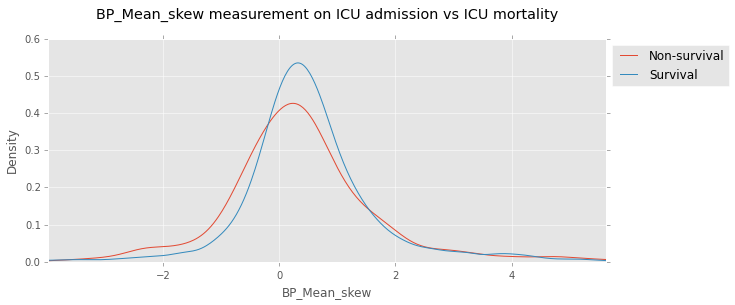

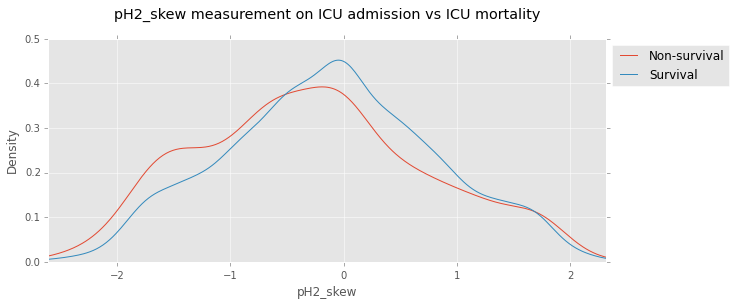

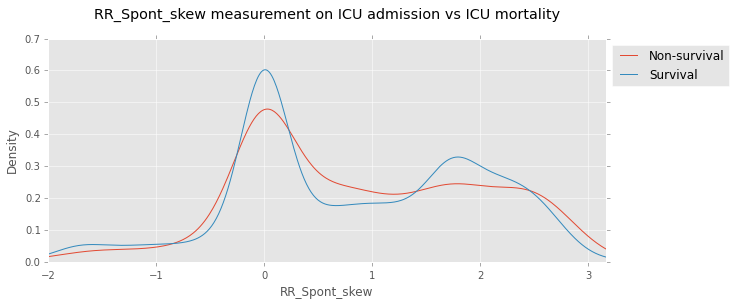

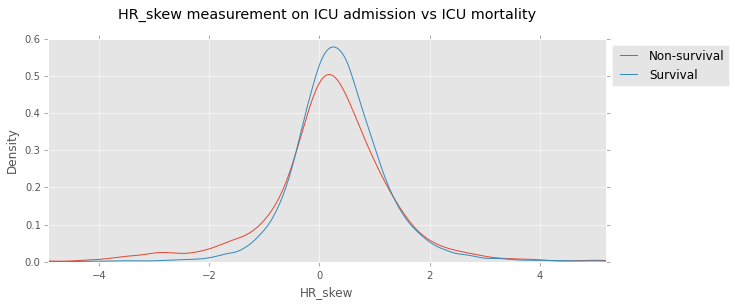

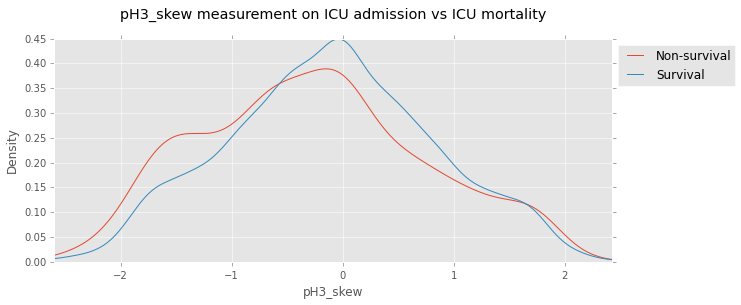

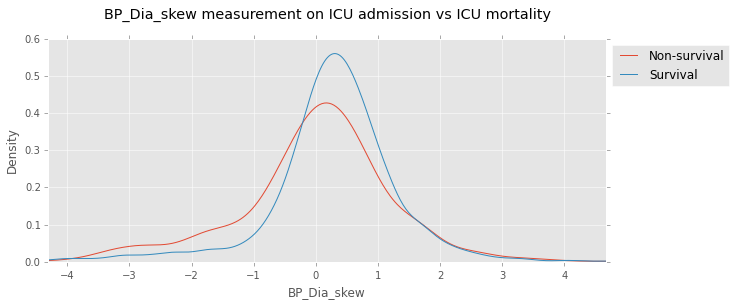

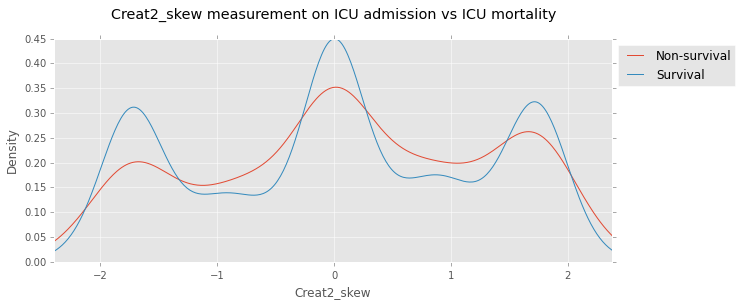

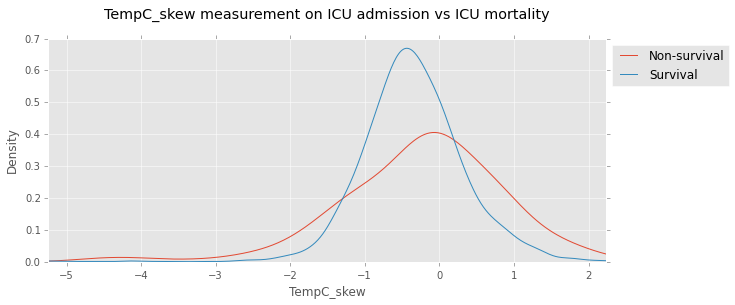

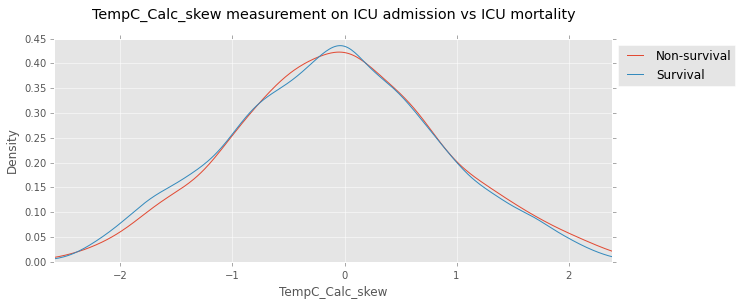

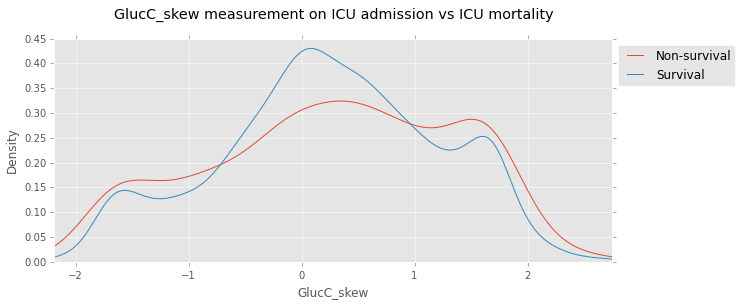

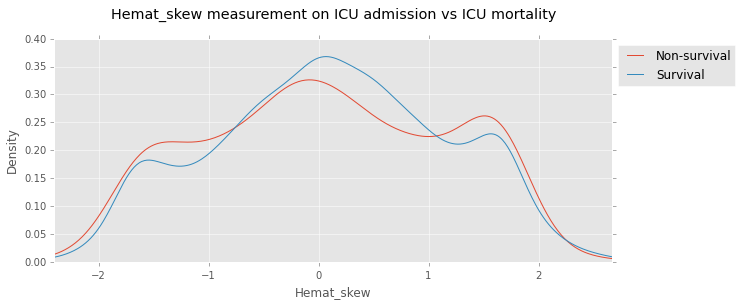

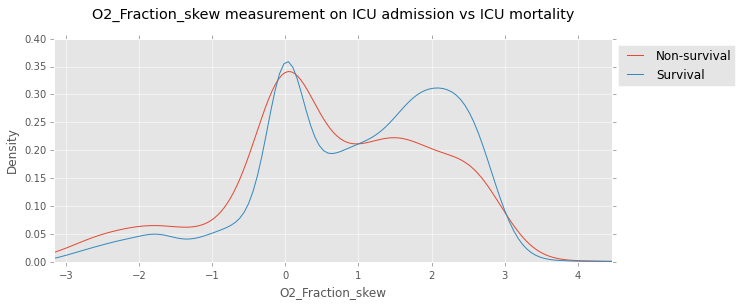

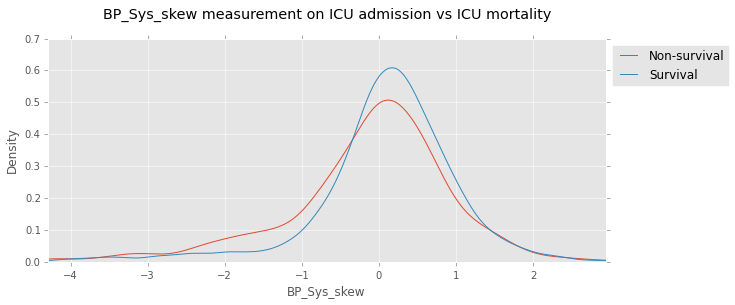

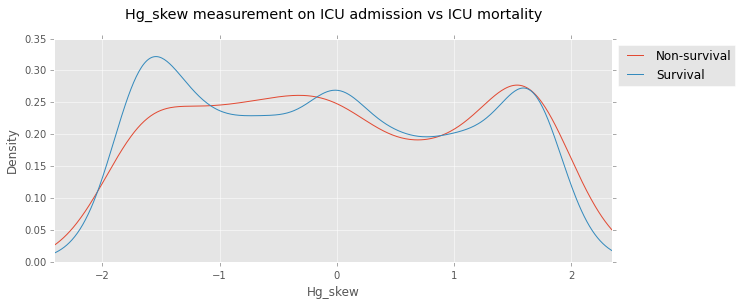

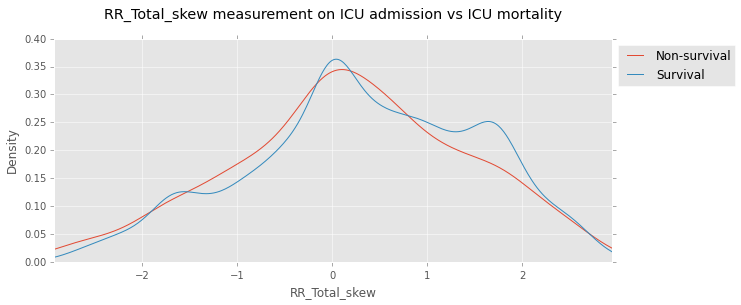

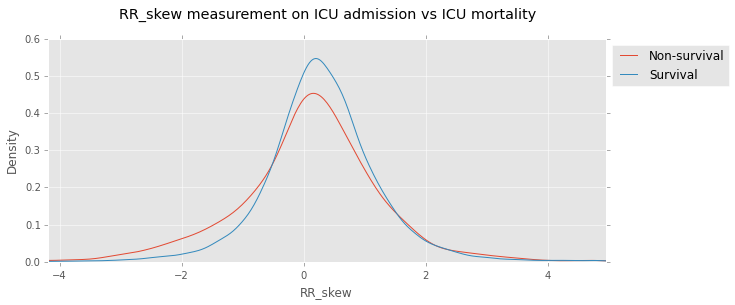

In [46]:
#mean_dict[mean_dict.cols()[0]].head()
# SKEW_DICT[COL] = FRAME OF SUBJECT_ID, WHATEVER VARIABLE IS BEING INDICATED BY COL, 
# SURVIVAL AND GENDER
for col in skew_dict.keys():
    # plot
    # print col
    dummy = skew_dict[col][skew_dict[col].gender == 'M'] 
   

    '''
    #display(dummy.head())
    # MAY WANT TO DO THIS WITH SURVIVOR AND NON-SURVIVOR GROUPS 

    all_outliers = []
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(dummy[dummy.columns[0]].dropna(), 25)
    #print Q1
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(dummy[dummy.columns[0]].dropna(), 75)
    #print Q3
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3 - Q1)
    # Display the outliers
    # print "Data points considered outliers for the feature '{}':".format(feature)
    # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
    # ~ == not
    all_outliers.extend(dummy[~((dummy[dummy.columns[0]] >= Q1 - step) & 
                              (dummy[dummy.columns[0]] <= Q3 + step))].index)
    # OPTIONAL: Select the indices for data points you wish to remove
    print "the total outlier indices = {}".format(len(all_outliers))
    
    outliers  = all_outliers #list(outlier_df[outlier_df.counts 1>= 2].indices.values)
    #print "the following data points are outliers and will be removed: \n{}".format(outliers)
    # Remove the outliers, if any were specified
    #display(outliers[:5])
    #boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)
    dummy.drop(outliers, inplace = True)# .reset_index(drop = True)
    
    '''    
    
    plt.subplots(figsize=(10,4))
    dummy[dummy.columns[0]][dummy.hospital_expired_flag==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival')
    dummy[dummy.columns[0]][dummy.hospital_expired_flag==0].dropna().plot.kde(
        alpha=1.0,label='Survival')

    # add title, labels etc.
    plt.title('{} measurement on ICU admission '.format(col) +
               'vs ICU mortality \n')
    plt.xlabel(col)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    
    
    plt.xlim(dummy[dummy.columns[0]].dropna().quantile(0.001), dummy[dummy.columns[0]].dropna().quantile(0.999))
    


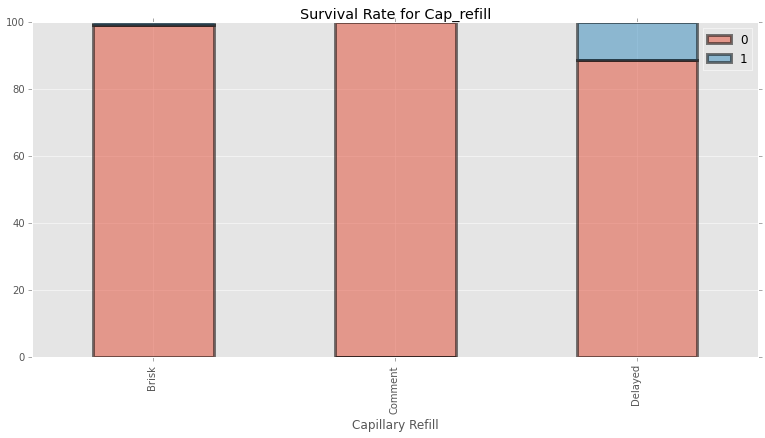

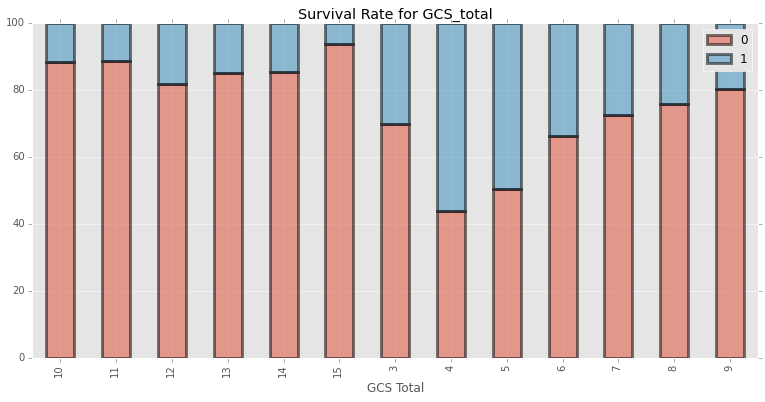

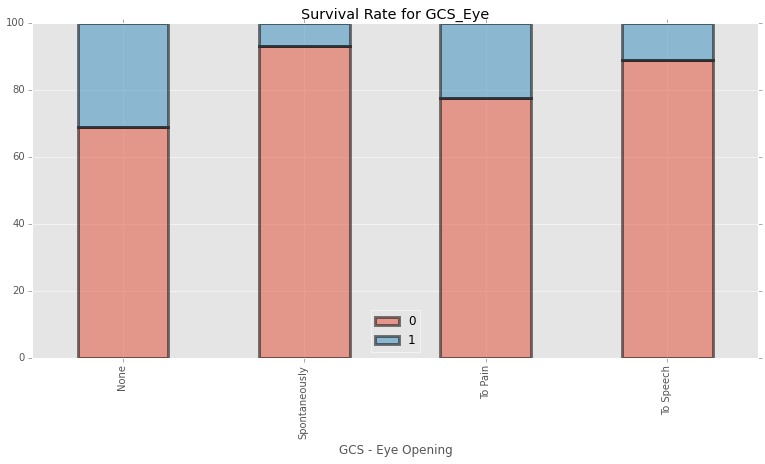

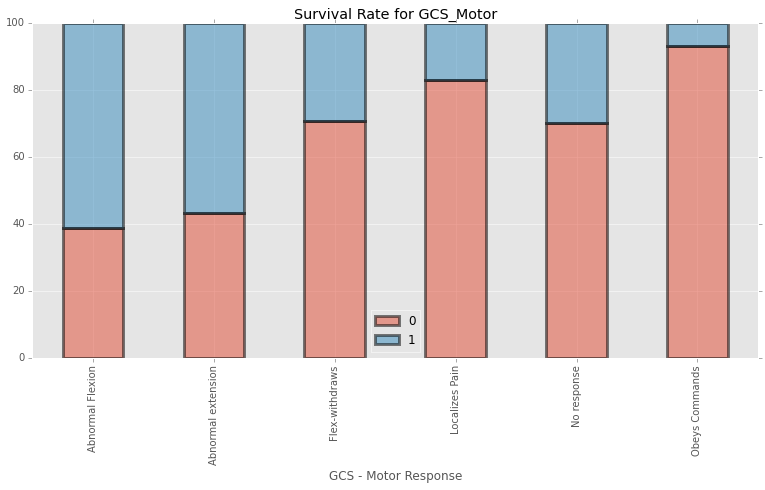

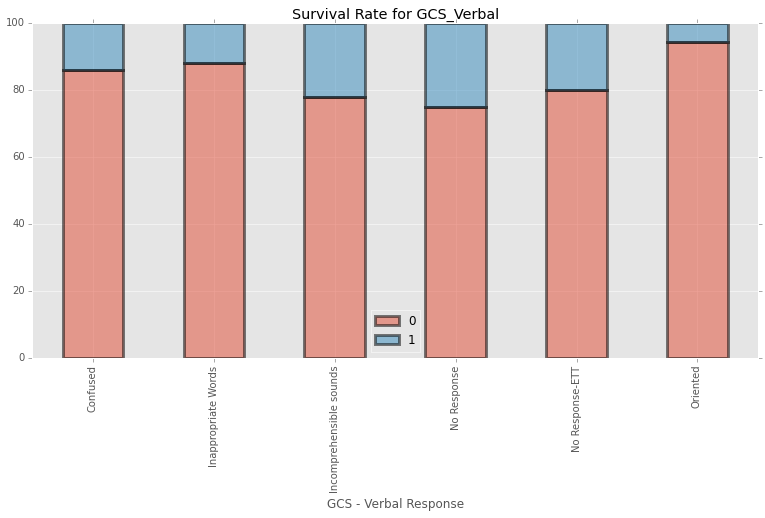

In [47]:
for col in cat_dict.keys():
    col2 = cat_dict_names[col]
    #print col
    #print col2
    vals = list(cat_dict[col][col2].unique())
    #display(vals)
    total = cat_dict[col].groupby(col2)[col2].count()
   
    dead = cat_dict[col][cat_dict[col].hospital_expired_flag == 1].groupby(col2)[col2].count()
    dead.name = 'Survivors'
    dead_percent = 100.00*(dead / total)
    live = cat_dict[col][cat_dict[col].hospital_expired_flag == 0].groupby(col2)[col2].count()
    live.name = 'Non_Survivors'
    live_percent = 100.00*(live / total)
    monkey = pd.concat([live_percent, dead_percent], axis = 1)

    #display(monkey)

    monkey.plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Survival Rate for " + col)

In [48]:
const_dict.keys()

['Weight', 'Height']

In [49]:
col = const_dict.keys()[0]
col2 = const_dict_names[col]
print "{}   {}".format(col, col2)

dead = const_dict[col][(const_dict[col].hospital_expired_flag == 0)&
                          (const_dict[col].gender == gend)&
                          (const_dict[col][col2] >20)&
                          (const_dict[col][col2] < 700)]
display(dead[dead[col2] > 500])
display(dead.describe())

Weight   Admission Weight (Kg)


NameError: name 'gend' is not defined

In [ ]:
for col in const_dict.keys():
    
    col2 = const_dict_names[col]
    vals = list(const_dict[col][col2].unique())
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        print gend
        dead = const_dict[col][(const_dict[col].hospital_expired_flag == 1)&
                              (const_dict[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = const_dict[col][(const_dict[col].hospital_expired_flag == 0)&
                              (const_dict[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
        #display(dummy.head())
        # MAY WANT TO DO THIS WITH SURVIVOR AND NON-SURVIVOR GROUPS 
        '''
        all_outliers = []
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(dummy[dummy.columns[0]].dropna(), 25)
        #print Q1
        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(dummy[dummy.columns[0]].dropna(), 75)
        #print Q3
        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)
        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        # ~ == not
        all_outliers.extend(dummy[~((dummy[dummy.columns[0]] >= Q1 - step) & 
                                  (dummy[dummy.columns[0]] <= Q3 + step))].index)
        # OPTIONAL: Select the indices for data points you wish to remove
        print "the total outlier indices = {}".format(len(all_outliers))
    
        outliers  = all_outliers #list(outlier_df[outlier_df.counts 1>= 2].indices.values)
        #print "the following data points are outliers and will be removed: \n{}".format(outliers)
        # Remove the outliers, if any were specified
        #display(outliers[:5])
        #boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)
        dummy.drop(outliers, inplace = True)# .reset_index(drop = True)    
        '''   
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].quantile(maxx)
        live_min = live[col2].quantile(minn)
        dead_max = dead[col2].quantile(maxx)
        dead_min = dead[col2].quantile(minn)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
    
    
        plt.subplots(figsize=(10,4))
        #live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.hist(bins = 100, alpha=0.3,label='Survivors')
        #live[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.hist(bins = 20, alpha=1.0,label='Non-Survivors')
    
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.hist(bins = 100, 
                                                                            alpha=0.3,label='Survivors')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.hist(bins = 100, 
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   
    
        print "{}    {}".format(maxlim, minlim)
        plt.xlim(minlim, maxlim)
    

In [ ]:
live[col2].head(10)

In [ ]:
display(type(live[col2]))
print live_max
live[col2].head()

In [ ]:
data2.columns

In [ ]:
data2 = data.drop_duplicates('icustay_id', keep = 'first')
data3 = data2.drop(['label', 'value', 'valuenum'], axis = 1)
data3.set_index(['icustay_id'], inplace = True)


for col in mean_dict.keys():
    col2 = mean_dict_names[col]
    data3 = data3.merge(pd.DataFrame(mean_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols


for col in med_dict.keys():
    col2 = med_dict_names[col]
    data3 = data3.merge(pd.DataFrame(med_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in std_dict.keys():
    col2 = std_dict_names[col]
    data3 = data3.merge(pd.DataFrame(std_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols

for col in skew_dict.keys():
    col2 = skew_dict_names[col]
    data3 = data3.merge(pd.DataFrame(skew_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in min_dict.keys():
    col2 = min_dict_names[col]
    data3 = data3.merge(pd.DataFrame(min_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in max_dict.keys():
    col2 = max_dict_names[col]
    data3 = data3.merge(pd.DataFrame(max_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in const_dict.keys():
    col2 = const_dict_names[col]
    data3 = data3.merge(pd.DataFrame(const_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols
    
for col in cat_dict.keys():
    col2 = cat_dict_names[col]
    data3 = data3.merge(pd.DataFrame(cat_dict[col][col2]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
    newcols = list(data3.columns)
    newcols.pop()
    newcols.append(col)
    data3.columns = newcols

data3['icustay_id'] = data3.index
cols = list(data3.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))


data3 = data3[cols]
data3.set_index(np.arange(data3.shape[0]), inplace = True)
data3.head()

In [ ]:
data3.to_csv('CHART_EVENTS_FIRST24_PROCESSED.csv')

In [ ]:
data_b = data3.dropna()
X_continuous = data4[list(data4.columns[data4.dtypes == 'float64'])]
y = data4['hospital_expire_flag']
display(X_continuous.shape)
display(y.shape)

below_zeros = list(X_continuous.columns[X_continuous.min() < 0])
below_zeros

for col in below_zeros:
    col_min = X_continuous[col].min()
    X_continuous[col] = X_continuous[col].apply(lambda x: x-col_min)

    
    
X_continuous.min()

In [ ]:
data4 = pd.DataFrame.from_csv('LAB_EVENTS_FIRST24_PROCESSED.csv')
data4.head()

In [ ]:
data3.set_index(['icustay_id'], inplace = True)
data4.set_index(['icustay_id'], inplace = True)
data4.drop('subject_id')

# ADD CODE TO LABEL LAB VS CHART CHART TIME
data3 = data3.merge(data4, left_index = True, right_index = True, 
                       how = 'left', sort = True, suffixes = ('_chart', '_lab'))

data3['icustay_id'] = data3.index
cols = list(data3.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
cols.insert(2, cols.pop(cols.index('Height')))
cols.insert(3, cols.pop(cols.index('Weight')))
cols.insert(4, cols.pop(cols.index('charttime_x')))
cols.insert(5, cols.pop(cols.index('charttime_y')))
cols.insert(6, cols.pop(cols.index('intime_x')))
cols.insert(7, cols.pop(cols.index('intime_y')))
cols.insert(8, cols.pop(cols.index('outtime_x')))
cols.insert(9, cols.pop(cols.index('outtime_y')))

data3 = data3[cols]
data3.set_index(np.arange(data3.shape[0]), inplace = True)

data3.head()

In [ ]:
data3.rename(columns = {'charttime_x':'charttime_chart', 'charttime_y':'charttime_lab', 
              'intime_x':'intime_chart', 'intime_y':'intime_lab', 
             'outtime_x':'outtime_chart', 'outtime_y':'outtime_lab'}, inplace = True)
data3.columns

In [ ]:
len(data3.columns)

In [ ]:
data4 = data3.dropna(thresh = 57)
data5 = data3.dropna(subset = ['BP_Dia_max'])

In [ ]:
for col in data5.columns:
    print "{} has  {} NaN values".format(col,data5[col].isnull().sum())

In [ ]:
data5.dropna(thresh = 50).head(10)

In [ ]:
for col in data4.columns:
    print "{} has  {} NaN values".format(col,data4[col].isnull().sum())

In [ ]:
#data3.drop(['admittime', 'intime', 'charttime', 'itemid', 'cgid', 'value', 
#            'valuenum', 'valueuom', 'label'], axis = 1, inplace = True)
#data3.drop(['itemid', 'angus'], axis = 1, inplace = True) 
#            'valuenum', 'valueuom', 'label'], axis = 1, inplace = True)

In [ ]:
display(data[(data.label=='WBC') & (data.valuenum.isnull())].head())

In [ ]:
print "CO        {}".format(CO_df.shape)
print "WBC       {}".format(WBC_df.shape)
print "RR        {}".format(RR_df.shape)
print "MAP       {}".format(MAP_df.shape)
print "HR        {}".format(HR_df.shape)
print "HR2       {}".format(HR2_df.shape)
print "CVP_med   {}".format(CVP_med_df.shape)
print "CVP_min   {}".format(CVP_min_df.shape)
print "pH        {}".format(pH_df.shape)
print "Lac_mean  {}".format(LAC_mean_df.shape)
print "Lac_min   {}".format(LAC_min_df.shape)

In [ ]:
ptnt_demog = pd.DataFrame.from_csv('PTNT_DEMOG_ANGUS_rev.csv')
ptnt_demog.shape

In [ ]:
display(data3.columns)
display(ptnt_demog.columns)

In [ ]:
ptnt_demog2 = ptnt_demog[['gender', 'marital_status', 'ethnicity', 'insurance', 'first_careunit', 
                          'age', 'hospital_expire_flag']]
ptnt_demog2.head()

## Merging the patient demographic and summary chart data

In [ ]:
data4 = data3.copy()
data4 = data4.merge(ptnt_demog2, left_index = True, right_index = True, how='left', sort = True)
data4.head()

In [ ]:
data4.isnull().sum()

In [ ]:
#df[np.isfinite(df['EPS'])]
#data4[np.isfinite(data4['CO_max'])].shape
#data5 = data4.drop(['CO_max', 'HR2_mean'], axis = 1)
# DROP COLUMNS WHERE THERE ARE (ARBITRARILY) < 7600 VALUES
data5 = data4[data4.columns[data4.isnull().sum() < 7600]]
data5.head()



In [ ]:
data5.dtypes

In [ ]:
float_vars = data5.dtypes[data5.dtypes == 'float'].index
cat_vars = data5.dtypes[data5.dtypes == 'object'].index
int_vars = data5.dtypes[data5.dtypes == 'int64'].index
cat_vars = cat_vars.drop(['value'])

In [ ]:
#int_vars = int_vars.drop(['subject_id', 'hospital_expire_flag', 'angus'])
#int_vars

In [ ]:
# HR2
display(data5.dropna().shape)
display(data5[data5.hospital_expire_flag == 1].dropna().shape)
display(data5[data5.hospital_expire_flag == 0].dropna().shape)

In [ ]:
for thing in cat_vars[1:2]:
    cats = list(data5[thing].unique())
    print cats

In [ ]:
for thing in cat_vars[:2]:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats



In [ ]:
for thing in cat_vars:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats

    for cat in cats:
        dead = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 1)].dropna().count()
        live = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 0)].dropna().count()
        total = float(live) + dead
        datadict[cat] = (live/total, dead/total)

    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + thing)
    plt.show()


In [ ]:
len(int_vars)
int_vars[1:len(int_vars)-1]

In [ ]:
for thing in int_vars[1:len(int_vars)-1]:
    datadict = dict()
    cats = list(data5[thing].unique())
    print thing
    print cats

    for cat in cats:
        dead = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 1)].dropna().count()
        live = data5[thing][(data5[thing] == cat) & (data5.hospital_expire_flag == 0)].dropna().count()
        #total = float(live) + dead
        #datadict[cat] = (live/total, dead/total)
        datadict[cat] = (live, dead)
    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + thing)
    plt.show()


In [ ]:
float_vars

In [ ]:
for thing in float_vars:
    # plot
    plt.subplots(figsize=(13,6))
    data5[thing][data5.hospital_expire_flag==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival')
    data5[thing][data5.hospital_expire_flag==0].dropna().plot.kde(
        alpha=1.0,label='Survival')
    
  

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(thing.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(thing)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data5[thing].dropna().quantile(0.99))
    
  

In [ ]:
dead_men = data5.gender[(data5['gender']=='M') & (data5.hospital_expire_flag ==1)].dropna().count()
dead_women = data5.gender[(data5['gender']=='F') & (data5.hospital_expire_flag ==1)].dropna().count()
live_men = data5.gender[(data5['gender']=='M') & (data5.hospital_expire_flag ==0)].dropna().count()
live_women = data5.gender[(data5['gender']=='F') & (data5.hospital_expire_flag ==0)].dropna().count()
survival = pd.DataFrame([[live_men, live_women], 
                        [dead_men, dead_women]], 
                       columns = ['Men', 'Women'],
                       index = ['Survivors', 'Non_Survivors'])
survival

In [ ]:
survival.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                             alpha = 0.5)

In [ ]:
np.arange(2)

In [ ]:
ind = np.arange(1,3)    # the x locations for the groups
width = 0.25       # the width of the bars: can also be len(x) sequence

plt.figure(figsize= (20,10))
p1 = plt.bar(ind - width/2, survival.iloc[0], width, color = 'green', edgecolor = 'black',
            linewidth = 3)
p2 = plt.bar(ind - width/2, survival.iloc[1], width, color = 'red', edgecolor = 'black', 
             linewidth = 3, bottom=survival.iloc[0])

plt.ylabel('Number of Patients')
plt.title('Survivors vs. Non-Survivors')
plt.xticks(ind, ('Men', 'Women'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Survivors', 'Non_Survivors'))

plt.show()

In [ ]:
#ax = skew_df.plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
#ax.set_ylabel("Skewness")
#data5.groupby(['hospital_expire_flag'])[['gender']].count().plot(kind='bar', stacked = True )
data5[cat_vars].plot.hist()

In [ ]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}
'''
# a list is created containing units of measure for the lab measurements
lab_units = ['g/dL',
        'mEq/L',
        'mEq/L',
        'mg/dL',
        '',
        'mEq/L',
        'mg/dL',
        'mg/dL',
        '%', 
        'g/dL',
        '',
        'mmol/L',
        'mmol/L',
        'mg/dL',
        'K/uL',
        'mEq/L',
        '',
        'sec',
        'mmol/L',
        '']

# currently using lab_measures and lab_units to create the dict. 
# could be done more succinctly using the dictionary described above
labs_dict = dict(zip(lab_measures, lab_units))
print labs_dict


In [ ]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = data[l][data.mort_icu==1].dropna().count()
    n_surv = data[l][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l][data.mort_icu==1].dropna().median()
    med_surv = data[l][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l][data.mort_icu==1].dropna().var()
    var_surv = data[l][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l][data.mort_icu==1].dropna().skew()
    skew_surv = data[l][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Generating box-plots for each variable for both survival and non-survival groups. 

In [ ]:
# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    #fig, ax1 = plt.subplots(figsize=(13, 6))
    #fig.canvas.set_window_title('A Boxplot Example')
    #plt.subplots(figsize=(13,6))
    #box_data = data[['mort_icu', l.lower()+'_1st']].dropna()
    data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
    #data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
    #    label='Non-survival (n={})'.format(n_nonsurv))
    plt.suptitle("")
    '''
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.box(
        label='Survival (n={})'.format(n_surv))
    '''
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    
   # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data[l.lower()+'_1st'].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    
    

## From the density plots above, a list of variables was generated for which the distribution was very similar between survival and non-survival groups. (Maybe include similarity threshold??)

In [ ]:
# Generate list of variables which, from density plots above, are similar between surivial and non-survival groups
cols_list = list(data.columns)
remove_list = ['chloride_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'platelet_1st']
for element in remove_list:
    cols_list.remove(element)
    
display(cols_list)

In [ ]:
# data4 includes all variables except those identified as similar between survival and non-survival groups. 
data2 = data[cols_list]
data2.head()

## Removing data points that include any NaN values

In [ ]:
# remove samples which have any values that are nan
data2 = data2.dropna()
data2.set_index(np.arange(data2.shape[0]), inplace = True)
data2.head()

## The survival rate calculated below indicates that 82% of patients survived. 

In [ ]:
dead = data2['mort_icu'][data2.mort_icu==1].count()
survivors = data2['mort_icu'][data2.mort_icu==0].count()
survival_rate = float(survivors)/(dead+survivors)
print "Number of  patients deceased = {}".format(dead)
print "Number of patients           = {}".format(dead + survivors)
print "Survival Rate                = {}".format(survival_rate * 100)

## Support Vector Machine Classification on un-processed data with variables selected based on visual inspection
The variables enumerated in 'remove_list' were observed for both survivors and non-survivors and appeared to be very similar in distribution. Because they appeared to be very similar for both groups, they were excluded as features for classification. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.30, random_state = 42)

clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, data2[data2.columns[1:]], data2['mort_icu'], cv=5)
display(scores)  


In [ ]:
clf_SVC.score(X_test, y_test)
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

## The Confusion Matrix indicates that the classifier simply predicts survival for each patient which, because 82% of the patients survived, results in 82% Accuracy. 

## Gaussian Naive Bayes Classification on un-processed data with variables selected based on visual inspection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.40, random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



## The Confusion Matrix indicates that the classifier predicts survival rates with ~78% accuracy with a mixture of predictions rather than predicting all survival as was the case for the SVM classifier. Unfortunately, the accuracy is not better than predicting all survivors. 

## Multi-Layer Perceptron Classification on un-processed data with variables selected based on visual inspection

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.20, random_state = 42)

clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(7, 4), random_state=1)

clf_MLP.fit(X_train, y_train)                         

display(clf_MLP.score(X_test, y_test))
y_predsMLP = clf_MLP.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)




## Creating a Dataframe of skewness measurements for the raw data and for different transforms to calculate what transform does the best job of normalizing the data

In [ ]:
# create dict from which we'll build skew measures dataframe
skew_dict2 = {data2.columns[1]:
              {
             'raw_skew': scats.skew(data2[data2.columns[1]]), 
             'sqrt_skew': scats.skew(np.sqrt(data2[data2.columns[1]])), 
             'log_skew': scats.skew(np.log(data2[data2.columns[1]].add(1))),  
             'boxcox_skew': scats.skew(scats.boxcox(data2[data2.columns[1]].add(1))[0])
             }
             }

print skew_dict2
skew_df = pd.DataFrame.from_dict(skew_dict2, orient = 'index')  
skew_df

In [ ]:
# re-order columns
skew_df = skew_df[['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew']]


In [ ]:
skew_df

In [ ]:
              
for col in data2.columns[2:]:
    raw_skew = scats.skew(data2[col])
    
    sqrt_skew = scats.skew(np.sqrt(data2[col]))
    log_skew = scats.skew(np.log(data2[col].add(1)))
        #print "{} logskew = {}".format(col, new_skew_val2)
    boxcox_skew = scats.skew(scats.boxcox(data2[col].add(1))[0])
    new_row = pd.Series([raw_skew, sqrt_skew, log_skew, boxcox_skew],
                        #index=['measurement', 'raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                        index=['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                       name = col)

    skew_df = skew_df.append(new_row)#, ignore_index = True)

skew_df

In [ ]:
skew_df.columns.name = 'Skewness Values'
skew_df.index.name = 'Lab Measures'

## The figure below shows the skewness values for each lab measurement for normalized data that has been transformed by taking the log, the square root and using the box-cox function. It can be seen that the box-cox function performed better than other transforms in reducing skewness. 


In [ ]:
ax = skew_df.plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
ax.set_ylabel("Skewness")

In [ ]:
#sqrt_norm_data = np.sqrt(data2_norm[data2_norm.columns[1:]])
#log_norm_data = np.log(data2_norm[data2_norm.columns[1:]].add(1))
boxcox_data = data2.copy()
for feature_name in data2.columns[1:]:
    boxcox_data[feature_name] = scats.boxcox(data2[feature_name].add(1))[0]

boxcox_data.head()

## Code to identify outliers in normalized data

In [ ]:
names_dict = {}
suffix = '_outliers'


for feature in boxcox_data.cols():
    if feature != 'mort_icu':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(boxcox_data[feature], 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(boxcox_data[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = boxcox_data[~((boxcox_data[feature] >= Q1 - step) & (boxcox_data[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove

## Code to remove datapoints from normalized data with 3 or more variables that are outliers

In [ ]:
all_outliers = []
for feature in names_dict.cols():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts >= 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)

In [ ]:

# I believe this can be done more efficiently with sklearn.preprocessing.scale
boxcox_data_scaled = boxcox_data2.copy()
for feature_name in boxcox_data2.columns[1:]:
#    max_value = data2[feature_name].max()
#    min_value = data2[feature_name].min()
#    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)
    boxcox_data_scaled[feature_name] = preprocessing.scale(boxcox_data_scaled[feature_name], with_mean = True, 
                                                  with_std = True)
    
display(boxcox_data_scaled.head())
display(boxcox_data.head())


In [ ]:
#remove_list

In [ ]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs_dict2 = labs_dict

# could be done more succinctly using the dictionary described above

for item in remove_list:
    del labs_dict2[item]

print labs_dict2
print boxcox_data_scaled.columns

import collections
labs_dict3 = collections.OrderedDict(sorted(labs_dict2.items()))
labs_dict3
'''

## Plotting frequency distribution for each lab measurement for both survival and non-survival groups. 

In [ ]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().count()
    n_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().median()
    med_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().median()
    var_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().var()
    var_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().var()
    skew_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().skew()
    skew_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna(),
                              boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    #plt.xlim(0, boxcox_data_scaled[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Performing PCA on box-cox transformed, scaled data with outliers removed

In [ ]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 4).fit(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], pca)


In [ ]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']) #,
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

## Scatterplot of Box-Cox transformed data with outliers removed. 

In [ ]:
pd.scatter_matrix(boxcox_data_scaled[1:], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(reduced_data, 
                                                    boxcox_data_scaled['mort_icu'], test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


## Box-Cox transformed data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], 
                                                    boxcox_data_scaled['mort_icu'], test_size = 0.40, random_state = 42)


clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)



In [ ]:
data[data.columns[5:]].head()

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [ ]:
boxcox_dead = boxcox_data_scaled[boxcox_data_scaled.mort_icu == 1]
boxcox_survivors = boxcox_data_scaled[boxcox_data_scaled.mort_icu == 0]
display(boxcox_dead.shape[0])
display(boxcox_survivors.shape[0])
boxcox_survivors_reduced = boxcox_survivors.sample(boxcox_dead.shape[0])
frames = [boxcox_survivors_reduced, boxcox_dead]
boxcox_even = pd.concat(frames)
boxcox_even.shape

In [ ]:
num_samps = boxcox_even.shape[0]
display(num_samps)

boxcox_even2 = boxcox_even.sample(n=num_samps)
#boxcox_even2.shape()
boxcox_even2.shape

In [ ]:
boxcox_even2.head(10)

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.40, 
                                                    random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


## Support Vector Machine Classification on un-processed data with variables selected based on visual inspection
The variables enumerated in 'remove_list' were observed for both survivors and non-survivors and appeared to be very similar in distribution. Because they appeared to be very similar for both groups, they were excluded as features for classification. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.30, 
                                                    random_state = 42)



clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, boxcox_data_scaled[boxcox_data_scaled.columns[1:]], 
                         boxcox_data_scaled['mort_icu'], cv=5)
display(scores)  
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

In [ ]:
display(clf_SVC.score(X_test, y_test))
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.30, 
                                                    random_state = 42)

clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)



In [ ]:
print "moncol"

In [ ]:
diagnoses_codes = pd.DataFrame.from_csv('IDC9_DEADLY_DIAGNOSES.csv')
diagnoses_codes.head()

In [ ]:
diagnoses_list = diagnoses_codes.icd9_code.unique()
diagnoses_list2 = diagnoses_codes.diagnosis.unique()
display(len(diagnoses_list))
display(len(diagnoses_list2))

In [ ]:
unique_codes = diagnoses_codes.drop_duplicates(['icd9_code', 'short_title'])
unique_codes.shape


In [ ]:
unique_codes.head()

In [ ]:
len(diagnoses_list)

In [ ]:
diag_counts = diagnoses_codes.icd9_code.value_counts()

In [ ]:
diag_counts[0:10]

In [ ]:
diagnoses_list[0:10]

In [ ]:
boxcox_data_scaled.columns

In [ ]:
boxcox_data_scaled_subset = boxcox_data_scaled[['mort_icu', 'albumin_1st', 'bicarbonate_1st', 'inr_1st', 'phosphate_1st',
                                                'ptt_1st']]
boxcox_data_scaled_subset.head()

In [ ]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 3).fit(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], pca)


In [ ]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']) #,
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

## Scatterplot of Box-Cox transformed data with outliers removed. 

## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [ ]:
feat_list = list(boxcox_data_scaled_subset.columns[1:])
feat_list

In [ ]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(boxcox_data_scaled_subset[feat_list], 
                                                    boxcox_data_scaled_subset['mort_icu'], 
                                                    test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)
